In [358]:
import read_inflow_scenarios


# Native libraries
import os
import math
# Essential Libraries
import time
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
# Preprocessing
from sklearn.preprocessing import MinMaxScaler
from fcmeans import FCM
# Algorithms
from minisom import MiniSom
from hyperopt import fmin, tpe, hp
from hyperopt import Trials,STATUS_OK
## SVM and GAK

In [2]:
data = pd.read_csv('data/regulated_inflow.csv', sep=';', index_col=[0])
data = pd.DataFrame(data)
udata = pd.read_csv('data/unregulated_inflow.csv', sep=';', index_col=[0])
udata = pd.DataFrame(udata)

In [3]:
regulated_sum=data.sum(axis=1)
unregulated_sum=udata.sum(axis=1)

In [4]:
### aggregated inflow energy
aggregated=regulated_sum+unregulated_sum


In [429]:
inflow_scenarios = read_inflow_scenarios.read_inflow_scenarios()
inflow_data_unregulated = {
    str(mod): {scen: inflow_scenarios['unregulated'][scen][str(mod)] for k in range(1, 52) for scen in range(50)}
    for mod in range(49901, 49913)}
inflow_data_regulated = {
    str(mod): {scen: inflow_scenarios['regulated'][scen][str(mod)] for k in range(1, 52) for scen in range(50)} for
    mod in range(49901, 49913)}

Text(0, 0.5, 'Aggregated Inflow ($m^3/s$)')

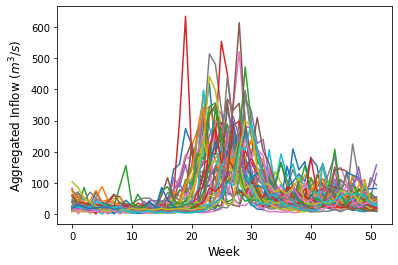

In [5]:
### scenarios illustrate
inflow = {}
for year in range(51):
    inflow[year] = {}
    data_2 = aggregated.iloc[year * 52:(year) * 52+52]## each time read 52 digit
    inflow[year] = data_2.reset_index(drop=True)
for year in range(51):
    plt.plot(inflow[year])
plt.xlabel('Week',size=12)
plt.ylabel('Aggregated Inflow ($m^3/s$)',size=12)

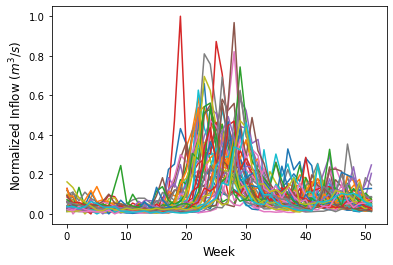

In [89]:
### inflow_scenarios_nor


flow= pd.DataFrame.from_dict(inflow,orient='index')
inflow_scenarios_nor=[]
for year in range(50):
    inflow_scenarios_nor.append(np.array((flow.iloc[year]-flow.min().min())/(flow.max().max()-flow.min().min())))

for i in range(50):
    plt.plot(inflow_scenarios_nor[i])
pd_flow= pd.DataFrame(inflow_scenarios_nor)
array_flow=pd_flow.to_numpy().reshape(50, 52, 1)
plt.xlabel('Week',size=12)
plt.ylabel('Normalized Inflow ($m^3/s$)',size=12)
plt.show()

In [355]:
## normal SOM

## start training function!!!

def training(flow,som_x,som_y,input_len,sig,learning_rate,iteration):
    #self, x, y, input_len, sigma, learning_rate,decay_function=asymptotic_decay,neighborhood_function='gaussian',
    # topology='rectangular',  'hexagonal'
    # activation_distance= Possible values: 'euclidean', 'cosine', 'manhattan', 'chebyshev'
    som = MiniSom(som_x, som_y,input_len, sigma=sig, learning_rate = learning_rate)#random_seed=10,neighborhood_function='gaussian'
    som.random_weights_init(flow) ## """Initializes the weights of the SOM picking random samples from data."""
    #som.random_weights_init(inflow_standard)

    start=time.time()
    '''Trains the SOM using all the vectors in data sequentially.'''
    #som.train_batch(inflow_scenarios_nor,iteration, verbose=True)
    som.train_batch(flow,iteration, verbose=True)
    end=time.time()-start
    print(end,'seconds')
    return som




def plot_som_series_averaged_center(som_x, som_y, win_map):
    fig, axs = plt.subplots(som_x,som_y,figsize=(30,15))
    fig.suptitle('Clusters',fontsize = 40)
    for x in range(som_x):
        for y in range(som_y):
            cluster = (x,y)
            if cluster in win_map.keys():
                for series in win_map[cluster]:
                    axs[cluster].plot(series,c="blue",alpha=0.7)

                axs[cluster].plot(np.average(np.vstack(win_map[cluster]),axis=0),c="red")

            cluster_number = x*som_y+y+1

            axs[cluster].set_title(f"Cluster {cluster_number}",fontsize = 15)
            axs[cluster].tick_params(axis='both', which='major', labelsize = 14 )
        axs[(2,0)].set_ylabel('Y normalization', fontsize=20,labelpad=8)
        axs[(2,0)].set_xlabel('Week', fontsize=20,labelpad=8)

    plt.show()

def plot_som_weight(som_x, som_y, win_map):
    fig, axs = plt.subplots(som_x,som_y,figsize=(20,15))
    fig.suptitle('Clusters',fontsize = 40)
    for x in range(som_x):
        for y in range(som_y):
            cluster = (x,y)
            if cluster in win_map.keys():
                for series in win_map[cluster]:
                    axs[cluster].plot(series,c="grey",alpha=0.5)

                axs[cluster].plot(som.get_weights()[x,y],c="green")

            cluster_number = x*som_y+y+1

            axs[cluster].set_title(f"Cluster {cluster_number}",fontsize = 15)
            axs[cluster].tick_params(axis='both', which='major', labelsize = 14 )
        axs[(2,0)].set_ylabel('Y normalization', fontsize=20,labelpad=8)
        axs[(2,0)].set_xlabel('Week', fontsize=20,labelpad=8)

    plt.show()

In [356]:
som_x=3
som_y=3
def hyperpara(flow,sig,lr):
    input_len=len(flow[0])
    iteration=1000


    space = {
            'sig': hp.uniform('sig',0,sig),
            'learning_rate' : hp.uniform('learning_rate',0,lr)
    }

    loss_val=[]

    def som_fn(space):

        sig=space['sig']
        learning_rate = space['learning_rate']



        val= MiniSom(x=som_x,y=som_y,input_len=input_len,sigma=sig,learning_rate=learning_rate,random_seed=0).quantization_error(flow)#inflow_scenarios_nor,random_seed=5,neighborhood_function='gaussian'
        loss_val.append(val)
        return {'loss':val,'status':STATUS_OK}#

    trials =Trials()

    best= fmin(
        fn=som_fn,space=space,algo=tpe.suggest,
        max_evals=100,trials=trials)

    print('best:{}'.format(best))

    '''
    for i,trial in enumerate(trials.trials[:1]):

        print(i,trial)
    '''


    sigma=best['sig']
    learning_rate = best['learning_rate']



    #print('x :{}\ny: {}\ninput_len :{}\nsigma: {}\nlearning_rate: {}'.format(som_x,som_y,input_len,sigma,learning_rate))
    som= training(flow,som_x,som_y,input_len,sigma,learning_rate,iteration)
    return som

100%|██████████| 100/100 [00:00<00:00, 249.08trial/s, best loss: 1.387221094162468]
best:{'learning_rate': 0.5683796980155162, 'sig': 1.0218481503242924}
 [ 1000 / 1000 ] 100% - 0:00:00 left 
 quantization error: 0.36394511632450616
0.08592748641967773 seconds


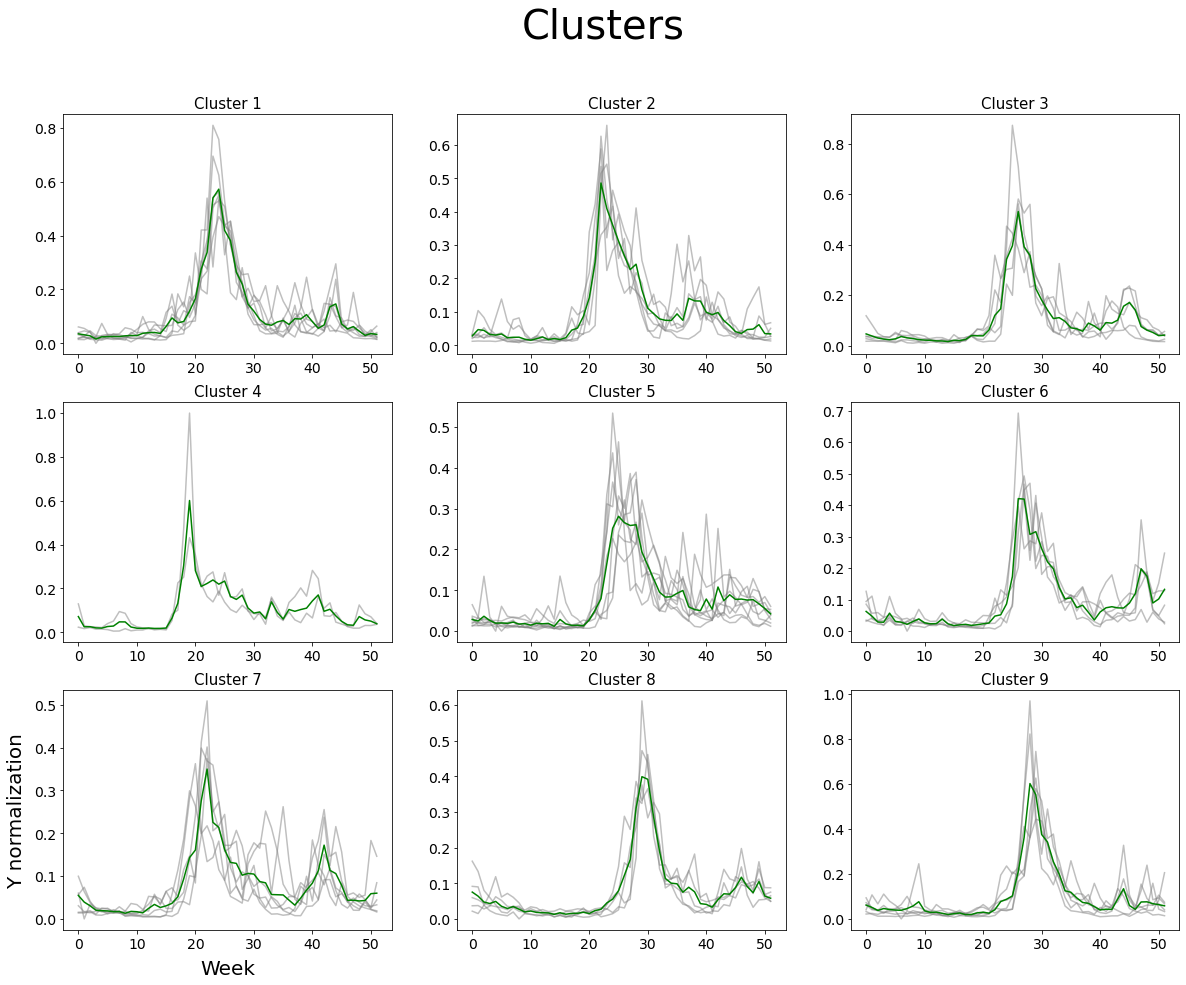

In [489]:
## regulated 49904
som=hyperpara(inflow_scenarios_nor,2,2)
win_map = som.win_map(inflow_scenarios_nor)
#100%|██████████| 100/100 [00:00<00:00, 327.39trial/s, best loss: 1.387221094162468]
#best:{'learning_rate': 0.9077657305453477, 'sig': 1.0650624616322022}
plot_som_weight(som_x, som_y, win_map)

In [490]:

def locate(flow,map):
    label={}

    for x in range(som_x):
        for y in range(som_y):
            cluster = (x,y)
            #if cluster in win_map.keys():
            for j in range(len(map[cluster])):
                for i in range(50):

                    if (map[cluster][j].all==flow[i].all):
                        label.update({i:(cluster)})
    return label


## get which one is clustered
def find_label(flow,map,label):
    clustering_index={}
    for k in range(50):
        locate(flow,map)

    label_transform={(cluster):[]  for cluster in map.keys() }
    for index in label.keys():
        for i in label_transform.keys():
            if label[index]==i:
                label_transform[i].append(index+1)
    return label_transform



In [491]:
label=locate(inflow_scenarios_nor,win_map)
clustering_index= find_label(inflow_scenarios_nor,win_map,label)

In [492]:
clustering_index

{(1, 0): [1, 4],
 (0, 1): [2, 9, 10, 11, 12, 22],
 (2, 0): [3, 6, 7, 17, 18, 29],
 (0, 0): [5, 8, 13, 15, 16, 19, 23],
 (0, 2): [14, 20, 26, 27, 36],
 (1, 1): [21, 24, 30, 31, 33, 34, 39, 40],
 (2, 2): [25, 35, 37, 38, 43, 46],
 (1, 2): [28, 32, 41, 44, 45],
 (2, 1): [42, 47, 48, 49, 50]}

In [493]:

prob = {}
j=0
for k, cluster in enumerate(clustering_index):
    x = len(clustering_index[cluster])/50
    prob[j]=x
    j += 1




In [494]:
max(data['49908'])

62.63521

In [499]:
## get average of all
regulated = {}

for module in inflow_data_regulated.keys():
    regulated_module = {}

    j = 0
    for cluster in clustering_index.keys():
        #print(cluster)
        x = 0

        for list in clustering_index[cluster]:
            #print(list)
            a = pd.DataFrame(inflow_data_regulated[str(module)][list - 1])
            x = a + x
            # print('x',x)
        regulated_module[j] = x / len(clustering_index[cluster])

        j += 1
    regulated[module] = regulated_module



unregulated = {}

for module in inflow_data_unregulated.keys():
    unregulated_module = {}

    j = 0
    for cluster in clustering_index.keys():
    # print(cluster)
        x = 0

        for list in clustering_index[cluster]:
            #print(list)
            a = pd.DataFrame(inflow_data_unregulated[str(module)][list - 1])
            x = a + x
            # print('x',x)
        unregulated_module[j] = x / len(clustering_index[cluster])

        j += 1
    unregulated[module] = unregulated_module


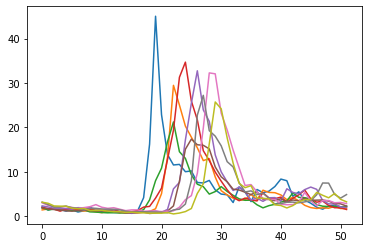

In [500]:

for i in range(9):
    plt.plot(regulated['49908'][i])

In [501]:
max(regulated['49908'][0].values)

array([45.041567])

In [502]:
prob

{0: 0.04, 1: 0.12, 2: 0.12, 3: 0.14, 4: 0.1, 5: 0.16, 6: 0.12, 7: 0.1, 8: 0.1}

In [363]:
### DTW-SOM
import dtwsom
from pyclustering.nnet.som import type_conn

In [364]:
rows = 3
cols = 3

structure = type_conn.grid_four
dtw_params = dtwsom.DtwParameters(window=100)
network = dtwsom.DtwSom(rows, cols, structure, dtw_params=dtw_params)
network.train(inflow_scenarios_nor, 10)

Epoch 1 achieved an average quantization error of 0.2135
Epoch 2 achieved an average quantization error of 0.2177
Epoch 3 achieved an average quantization error of 0.2188
Epoch 4 achieved an average quantization error of 0.2175
Epoch 5 achieved an average quantization error of 0.2179
Epoch 6 achieved an average quantization error of 0.217
Epoch 7 achieved an average quantization error of 0.2135
Epoch 8 achieved an average quantization error of 0.2079
Epoch 9 achieved an average quantization error of 0.2048
Epoch 10 achieved an average quantization error of 0.2028


10

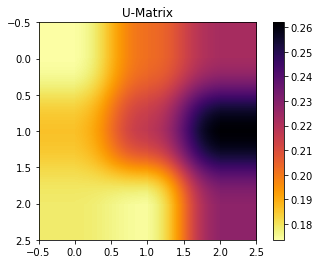

In [365]:
network.show_distance_matrix()

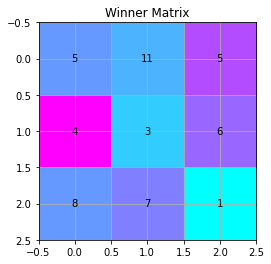

In [366]:
network.show_winner_matrix()

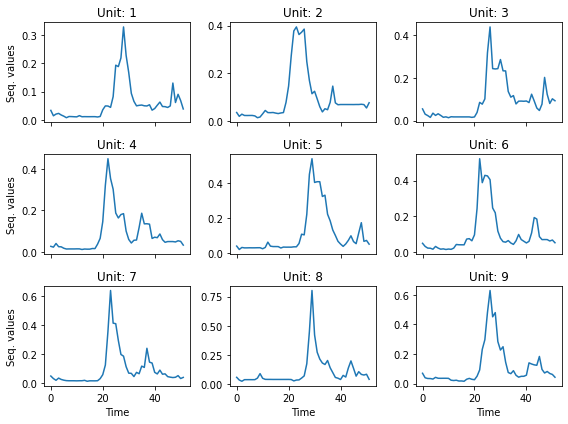

In [367]:
n_neurons = network._size
fig, axs = plt.subplots(rows,cols,figsize=(8, 6), sharex=True)
for neuron_index in range(n_neurons):
    col = math.floor(neuron_index/rows)
    row = neuron_index % rows
    neuron_weights = network._weights[neuron_index]
    axs[col, row].plot(np.arange(len(neuron_weights)), neuron_weights, label=str(neuron_index))
    axs[col, row].set_title("Unit: "+str(neuron_index+1))
    if row == 0:
        axs[col, row].set_ylabel("Seq. values")
    if col == 2:
        axs[col, row].set_xlabel("Time")
plt.tight_layout()
plt.show()

In [508]:
## Get clusters

y_clusters=network.capture_objects
Y_c=[]
for i in range(50):
    for a,b in enumerate(y_clusters):
        for j in range(len(b)):
            if b[j]==i:
                Y_c.append(a)





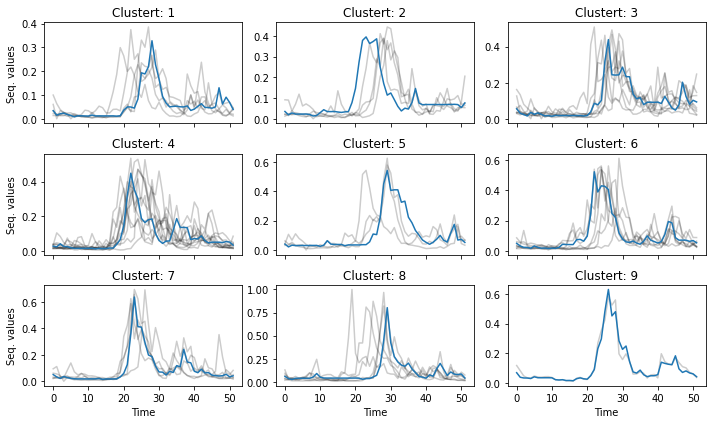

In [509]:
network.capture_objects
n_neurons = network._size
fig, axs = plt.subplots(rows, cols, figsize=(10, 6), sharex=True)
for neuron_index in range(n_neurons):
    col = math.floor(neuron_index / rows)
    row = neuron_index % rows
    cluster_list = network.capture_objects[neuron_index]
    for member_index in cluster_list:
        axs[col, row].plot(np.arange(len(inflow_scenarios_nor[member_index])), inflow_scenarios_nor[member_index], 'k-',
                           alpha=.2)
    neuron_weights = network._weights[neuron_index]
    axs[col, row].plot(np.arange(len(neuron_weights)), neuron_weights, label=str(neuron_index))
    axs[col, row].set_title("Cluster: " + str(neuron_index + 1))
    if row == 0:
        axs[col, row].set_ylabel("Seq. values")
    if col == 2:
        axs[col, row].set_xlabel("Time")
plt.tight_layout()
plt.show()

In [510]:
### shapelets method

#Learning Shapelets (shape-based clustering)

from sklearn.metrics import accuracy_score
import tensorflow as tf
from tslearn.shapelets import LearningShapelets, \
    grabocka_params_to_shapelet_size_dict
from tslearn.utils import ts_size
from matplotlib import cm
import pylab as pl

In [511]:
# creat training and testing data set
lab=np.ones((52,))
lab_test=np.ones((52,))
X_train = array_flow ##
X_test = array_flow##
y_train=Y_c  ##
y_test=Y_c
n_ts, ts_sz = X_train.shape[:2] ## ts No of scenarios ts_sz time stamps
n_classes = len(set(y_train))

In [512]:
# Set the number of shapelets per size as done in the original paper
shapelet_sizes = grabocka_params_to_shapelet_size_dict(n_ts=n_ts,
                                                       ts_sz=ts_sz,
                                                       n_classes=n_classes,
                                                       l=0.1,
                                                       r=1)
#shapelet_sizes = {10: 3}
# Define the model using parameters provided by the authors (except that we
# use fewer iterations here)
shp_clf = LearningShapelets(n_shapelets_per_size=shapelet_sizes,
                            optimizer=tf.optimizers.Adam(learning_rate=0.01),
                            batch_size=1600,
                            weight_regularizer=.0001,
                            max_iter=2000,
                            random_state=42,
                            scale=False,
                            verbose=0)
shp_clf.fit(X_train, y_train)
distances = shp_clf.transform(X_train)
weights, biases = shp_clf.get_weights("classification")

C:\Users\jinghaow\software\Anaconda3\envs\Clustering\lib\site-packages\tslearn\shapelets\shapelets.py:354: FutureWarning: The default value for 'scale' is set to False in version 0.4 to ensure backward compatibility, but is likely to change in a future version.
  warnings.warn("The default value for 'scale' is set to False "


In [513]:
# We will plot our distances in a 2D space
distances = shp_clf.transform(X_train)
weights, biases = shp_clf.get_weights('classification')

In [374]:
distances

array([[18.603193 , 30.544544 , 11.498621 ,  7.919243 ],
       [17.960989 , 30.625736 , 11.463828 ,  7.988712 ],
       [18.623318 , 30.58199  , 11.4970665,  7.955522 ],
       [17.049734 , 30.569853 , 10.411078 ,  7.544065 ],
       [18.295382 , 30.553497 , 11.272498 ,  7.867624 ],
       [19.039495 , 30.576893 , 11.689434 ,  7.8182006],
       [19.150906 , 30.563955 , 11.969977 ,  7.9598346],
       [16.609877 , 30.544306 , 10.6387   ,  7.8601403],
       [18.619215 , 30.566404 , 11.651524 ,  7.899915 ],
       [17.842442 , 30.579817 , 11.228036 ,  7.975412 ],
       [17.689554 , 30.58816  , 11.401049 ,  7.9435296],
       [17.89058  , 30.580378 , 11.171047 ,  7.9614854],
       [17.907972 , 30.572027 , 11.231252 ,  7.951729 ],
       [16.508326 , 30.623825 , 10.583781 ,  7.9636955],
       [17.920624 , 30.56573  , 11.2771225,  7.814962 ],
       [17.96353  , 30.502424 , 11.0495825,  7.8230143],
       [18.803123 , 30.562504 , 11.698891 ,  7.8961997],
       [18.233076 , 30.60004  ,

Correct classification rate: 0.62


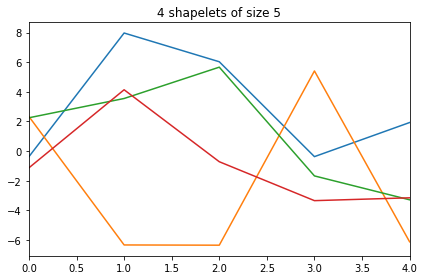

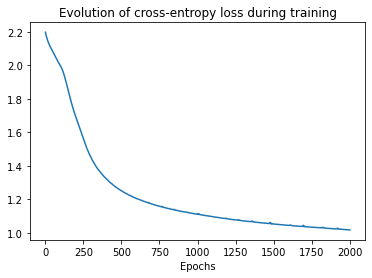

In [514]:

# Make predictions and calculate accuracy score
pred_labels = shp_clf.predict(X_test)
print("Correct classification rate:", accuracy_score(y_test, pred_labels))

# Plot the different discovered shapelets
plt.figure()
for i, sz in enumerate(shapelet_sizes.keys()):
    plt.subplot(len(shapelet_sizes), 1, i + 1)
    plt.title("%d shapelets of size %d" % (shapelet_sizes[sz], sz))
    for shp in shp_clf.shapelets_:
        if ts_size(shp) == sz:
            plt.plot(shp.ravel())
    plt.xlim([0, max(shapelet_sizes.keys()) - 1])

plt.tight_layout()
plt.show()

# The loss history is accessible via the `model_` that is a keras model
plt.figure()
plt.plot(np.arange(1, shp_clf.n_iter_ + 1), shp_clf.history_["loss"])
plt.title("Evolution of cross-entropy loss during training")
plt.xlabel("Epochs")
plt.show()

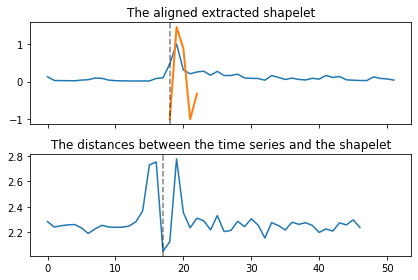

In [515]:
from tslearn.preprocessing import TimeSeriesScalerMeanVariance

#n_shapelets = sum(shapelet_sizes.values())
#distances = shp_clf.transform(X_train)
#weights, biases = shp_clf.get_weights("classification")
predicted_locations = shp_clf.locate(X_train)

f, ax = plt.subplots(2, 1, sharex=True)

# Plot the shapelet and align it on the best matched time series. The optimizer
# will often enlarge the shapelet to create a larger gap between the distances
# of both classes. We therefore normalize the shapelet again before plotting.
test_ts_id = np.argmin(np.sum(distances, axis=1))
shap = shp_clf.shapelets_[0]
shap =TimeSeriesScalerMeanVariance().fit_transform(shap.reshape(1, -1, 1)).flatten()
pos = predicted_locations[test_ts_id, 0]
ax[0].plot(X_train[test_ts_id].ravel())
ax[0].plot(np.arange(pos, pos + len(shap)), shap, linewidth=2)
ax[0].axvline(pos, color='k', linestyle='--', alpha=0.5)
ax[0].set_title("The aligned extracted shapelet")

# We calculate the distances from the shapelet to the timeseries ourselves.
distances1 = []
time_series = X_train[test_ts_id].ravel()
for i in range(len(time_series) - len(shap)):
    distances1.append(np.linalg.norm(time_series[i:i+len(shap)] - shap))
ax[1].plot(distances1)
ax[1].axvline(np.argmin(distances1), color='k', linestyle='--', alpha=0.5)
ax[1].set_title('The distances between the time series and the shapelet')

plt.tight_layout()
plt.show()

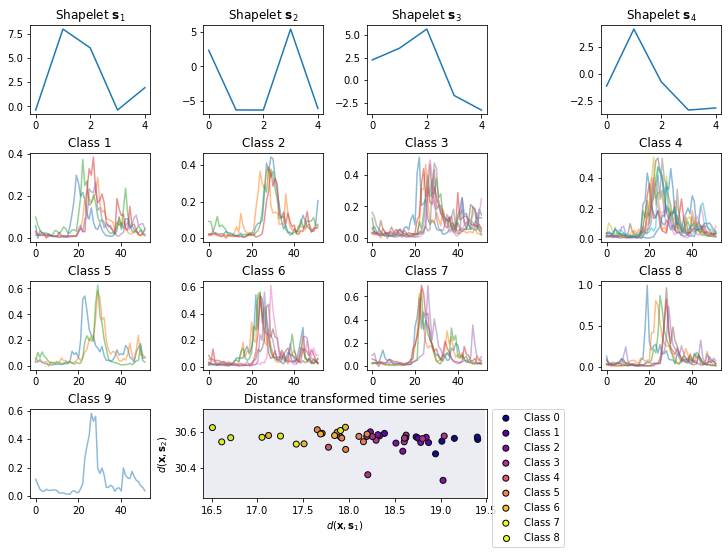

In [516]:
#distances = shp_clf.transform(X_train)
#weights, biases = shp_clf.get_weights('classification')

# Create a grid for our two shapelets on the left and distances on the right
plasma = cm.get_cmap('plasma')
fig = plt.figure(constrained_layout=True,figsize=[10,15])#,dpi=1000
gs = fig.add_gridspec(10, 12)
fig_ax1a = fig.add_subplot(gs[0, :3])
fig_ax1b = fig.add_subplot(gs[0, 3:6])
fig_ax1c = fig.add_subplot(gs[0, 6:9])
fig_ax1d = fig.add_subplot(gs[0, 9:])
fig_ax2a = fig.add_subplot(gs[1, :3])
fig_ax2b = fig.add_subplot(gs[1, 3:6])
fig_ax2c = fig.add_subplot(gs[1, 6:9])
fig_ax2d = fig.add_subplot(gs[1, 9:])
fig_ax2e= fig.add_subplot(gs[2, :3])
fig_ax2f= fig.add_subplot(gs[2, 3:6])
fig_ax1g= fig.add_subplot(gs[2, 6:9])
fig_ax1h= fig.add_subplot(gs[2, 9:])
fig_ax1i= fig.add_subplot(gs[3, 0:3])
fig_ax4 = fig.add_subplot(gs[3, 3:9])



# Plot our two shapelets on the left side
fig_ax1a.plot(shp_clf.shapelets_[0])
fig_ax1a.set_title('Shapelet $\mathbf{s}_1$')

fig_ax1b.plot(shp_clf.shapelets_[1])
fig_ax1b.set_title('Shapelet $\mathbf{s}_2$')

fig_ax1c.plot(shp_clf.shapelets_[2])
fig_ax1c.set_title('Shapelet $\mathbf{s}_3$')

fig_ax1d.plot(shp_clf.shapelets_[3])
fig_ax1d.set_title('Shapelet $\mathbf{s}_4$')

# Create the time series of each class

for i, subfig in enumerate([fig_ax2a, fig_ax2b,fig_ax2c,fig_ax2d,fig_ax2e,fig_ax2f,fig_ax1g,fig_ax1h,fig_ax1i]):
    index= [y for y, x in enumerate(y_train) if x == i]
    for j in index:
        ts=X_train[j]
        subfig.plot(ts.flatten(), alpha=0.5)
        subfig.set_title('Class {}'.format(i + 1))
#fig.text(x=.15, y=.02, s='Input time series', fontsize=12)

# Create a scatter plot of the 2D distances for the time series of each class.
for i, y in enumerate(np.unique(y_train)):

    fig_ax4.scatter(distances[y_train == y][:, 0],
                    distances[y_train == y][:, 1],
                    c=[plasma(i/7)] * np.sum(y_train == y),
                    edgecolors='k',
                    label='Class {}'.format(y))

# Create a meshgrid of the decision boundaries
xmin = np.min(distances[:, 0]) - 0.1
xmax = np.max(distances[:, 0]) + 0.1
ymin = np.min(distances[:, 1]) - 0.1
ymax = np.max(distances[:, 1]) + 0.1
xx, yy = np.meshgrid(np.arange(xmin, xmax, (xmax - xmin)/200),
                        np.arange(ymin, ymax, (ymax - ymin)/200))
Z = []
for x, y in np.c_[xx.ravel(), yy.ravel()]:
    Z.append(np.argmax([biases[i] + weights[0][i]*x + weights[1][i]*y
                           for i in range(1)]))
Z = np.array(Z).reshape(xx.shape)
cs = fig_ax4.contourf(xx, yy, Z / 3,  alpha=0.1)

fig_ax4.legend(loc='lower left',bbox_to_anchor=( 1,-0.6))
fig_ax4.set_xlabel('$d(\mathbf{x}, \mathbf{s}_1)$')
fig_ax4.set_ylabel('$d(\mathbf{x}, \mathbf{s}_2)$')
fig_ax4.set_xlim((xmin, xmax))
fig_ax4.set_ylim((ymin, ymax))
fig_ax4.set_title('Distance transformed time series')
plt.show()

In [517]:
# PAA transform (and inverse transform) of the data
from tslearn.generators import random_walks
from tslearn.preprocessing import TimeSeriesScalerMeanVariance
from tslearn.piecewise import PiecewiseAggregateApproximation
from tslearn.piecewise import SymbolicAggregateApproximation, \
    OneD_SymbolicAggregateApproximation

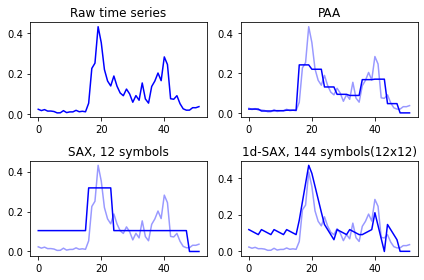

In [519]:



n_paa_segments = 12
paa = PiecewiseAggregateApproximation(n_segments=n_paa_segments)
paa_dataset_inv = paa.inverse_transform(paa.fit_transform(X_train))

# SAX transform
n_sax_symbols = 12
sax = SymbolicAggregateApproximation(n_segments=n_paa_segments,
                                     alphabet_size_avg=n_sax_symbols)
sax_dataset_inv = sax.inverse_transform(sax.fit_transform(X_train))

# 1d-SAX transform
n_sax_symbols_avg = 12
n_sax_symbols_slope = 12
one_d_sax = OneD_SymbolicAggregateApproximation(
    n_segments=n_paa_segments,
    alphabet_size_avg=n_sax_symbols_avg,
    alphabet_size_slope=n_sax_symbols_slope)
transformed_data = one_d_sax.fit_transform(X_train)
one_d_sax_dataset_inv = one_d_sax.inverse_transform(transformed_data)

plt.figure()
plt.subplot(2, 2, 1)  # First, raw time series
plt.plot(X_train[0].ravel(), "b-")
plt.title("Raw time series")

plt.subplot(2, 2, 2)  # Second, PAA
plt.plot(X_train[0].ravel(), "b-", alpha=0.4)
plt.plot(paa_dataset_inv[0].ravel(), "b-")
plt.title("PAA")

plt.subplot(2, 2, 3)  # Then SAX
plt.plot(X_train[0].ravel(), "b-", alpha=0.4)
plt.plot(sax_dataset_inv[0].ravel(), "b-")
plt.title("SAX, %d symbols" % n_sax_symbols)

plt.subplot(2, 2, 4)  # Finally, 1d-SAX
plt.plot(X_train[0].ravel(), "b-", alpha=0.4)
plt.plot(one_d_sax_dataset_inv[0].ravel(), "b-")
plt.title("1d-SAX, %d symbols"
          "(%dx%d)" % (n_sax_symbols_avg * n_sax_symbols_slope,
                       n_sax_symbols_avg,
                       n_sax_symbols_slope))

plt.tight_layout()
plt.show()